In [1]:
# Protein Structure-Function ML Project
# Model Training Notebook

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Setup plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('notebook')

print("=== PROTEIN FUNCTION PREDICTION - MODEL TRAINING ===")

# Load the ML-ready dataset
ml_file = "../data/processed/ml_ready_dataset.pkl"
try:
    with open(ml_file, 'rb') as f:
        ml_dataset = pickle.load(f)
    
    X = ml_dataset['features']
    y = ml_dataset['labels']
    protein_names = ml_dataset['protein_names']
    feature_names = ml_dataset['feature_names']
    ec_classes = ml_dataset['ec_classes']
    
    print(f"✓ Loaded ML dataset successfully")
    print(f"  Features shape: {X.shape}")
    print(f"  Labels shape: {y.shape}")
    print(f"  Number of features: {len(feature_names)}")
    print(f"  EC classes: {ec_classes}")
    print(f"  Proteins: {len(protein_names)}")
    
except FileNotFoundError:
    print("❌ ML dataset not found. Please complete notebook 02 first.")
    raise

# Display class distribution
from collections import Counter
class_counts = Counter(y)
print(f"\n=== CLASS DISTRIBUTION ===")
for ec_class in sorted(class_counts.keys()):
    count = class_counts[ec_class]
    percentage = (count / len(y)) * 100
    print(f"EC {ec_class}: {count:2d} proteins ({percentage:4.1f}%)")

# Encode labels for sklearn (convert string labels to numeric)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(f"\n✓ Labels encoded: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

=== PROTEIN FUNCTION PREDICTION - MODEL TRAINING ===
✓ Loaded ML dataset successfully
  Features shape: (33, 43)
  Labels shape: (33,)
  Number of features: 43
  EC classes: ['1', '2', '3', '4']
  Proteins: 33

=== CLASS DISTRIBUTION ===
EC 1:  6 proteins (18.2%)
EC 2:  8 proteins (24.2%)
EC 3: 11 proteins (33.3%)
EC 4:  8 proteins (24.2%)

✓ Labels encoded: {'1': np.int64(0), '2': np.int64(1), '3': np.int64(2), '4': np.int64(3)}


In [4]:
# Data Preprocessing and Split
print("=== DATA PREPROCESSING ===")

# Check for any remaining missing values
print(f"Missing values: {np.isnan(X).sum()}")
if np.isnan(X).sum() > 0:
    print("⚠ Handling missing values...")
    # Replace NaN with column means
    X = np.nan_to_num(X, nan=np.nanmean(X, axis=0))
    print("✓ Missing values replaced with column means")

# Feature scaling (important for SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"✓ Features scaled (mean=0, std=1)")
print(f"  Original range: {X.min():.3f} to {X.max():.3f}")
print(f"  Scaled range: {X_scaled.min():.3f} to {X_scaled.max():.3f}")

# Train-test split (80/20 with stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

# Convert back to original labels for interpretation
y_train_labels = label_encoder.inverse_transform(y_train)
y_test_labels = label_encoder.inverse_transform(y_test)

print(f"\n=== TRAIN/TEST SPLIT ===")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Check class distribution in splits
print(f"\nTraining set distribution:")
train_counts = Counter(y_train_labels)
for ec_class in sorted(train_counts.keys()):
    count = train_counts[ec_class]
    print(f"  EC {ec_class}: {count} proteins")

print(f"\nTest set distribution:")
test_counts = Counter(y_test_labels)
for ec_class in sorted(test_counts.keys()):
    count = test_counts[ec_class]
    print(f"  EC {ec_class}: {count} proteins")

# Get protein names for test set (for later analysis)
train_indices = train_test_split(range(len(protein_names)), test_size=0.2, random_state=42, stratify=y_encoded)[1]
test_protein_names = [protein_names[i] for i in train_indices]

print(f"✓ Data preprocessing complete")

=== DATA PREPROCESSING ===
Missing values: 0
✓ Features scaled (mean=0, std=1)
  Original range: -0.805 to 33470.635
  Scaled range: -4.742 to 4.742

=== TRAIN/TEST SPLIT ===
Training set: 26 samples
Test set: 7 samples

Training set distribution:
  EC 1: 5 proteins
  EC 2: 6 proteins
  EC 3: 9 proteins
  EC 4: 6 proteins

Test set distribution:
  EC 1: 1 proteins
  EC 2: 2 proteins
  EC 3: 2 proteins
  EC 4: 2 proteins
✓ Data preprocessing complete


In [5]:
# Train Random Forest Classifier
print("=== TRAINING RANDOM FOREST MODEL ===")

# Define parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize Random Forest
rf_base = RandomForestClassifier(random_state=42)

# Perform grid search with cross-validation
print("Performing hyperparameter optimization...")
rf_grid_search = GridSearchCV(
    rf_base, 
    rf_param_grid, 
    cv=3,  # 3-fold CV (small dataset)
    scoring='accuracy',
    n_jobs=-1
)

# Fit the grid search
rf_grid_search.fit(X_train, y_train)

# Get the best Random Forest model
rf_best = rf_grid_search.best_estimator_

print(f"✓ Best Random Forest parameters:")
for param, value in rf_grid_search.best_params_.items():
    print(f"  {param}: {value}")

# Train with best parameters and evaluate
rf_train_score = rf_best.score(X_train, y_train)
rf_test_score = rf_best.score(X_test, y_test)

print(f"\n=== RANDOM FOREST PERFORMANCE ===")
print(f"Training accuracy: {rf_train_score:.4f}")
print(f"Test accuracy: {rf_test_score:.4f}")

# Cross-validation scores
cv_scores = cross_val_score(rf_best, X_train, y_train, cv=5)
print(f"Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Make predictions
rf_predictions = rf_best.predict(X_test)
rf_predictions_labels = label_encoder.inverse_transform(rf_predictions)

# Classification report
print(f"\n=== DETAILED CLASSIFICATION REPORT ===")
print(classification_report(y_test_labels, rf_predictions_labels, target_names=[f"EC {ec}" for ec in sorted(ec_classes)]))

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_best.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n=== TOP 10 IMPORTANT FEATURES ===")
for i, row in feature_importance.head(10).iterrows():
    print(f"{i+1:2d}. {row['feature']:20s}: {row['importance']:.4f}")

# Save Random Forest model
import joblib
model_file = "../models/random_forest_model.pkl"
joblib.dump({
    'model': rf_best,
    'scaler': scaler,
    'label_encoder': label_encoder,
    'feature_names': feature_names
}, model_file)
print(f"\n✓ Random Forest model saved to {model_file}")

=== TRAINING RANDOM FOREST MODEL ===
Performing hyperparameter optimization...
✓ Best Random Forest parameters:
  max_depth: None
  min_samples_leaf: 1
  min_samples_split: 5
  n_estimators: 200

=== RANDOM FOREST PERFORMANCE ===
Training accuracy: 1.0000
Test accuracy: 0.7143
Cross-validation accuracy: 0.8067 ± 0.1272

=== DETAILED CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

        EC 1       0.00      0.00      0.00         1
        EC 2       0.67      1.00      0.80         2
        EC 3       0.67      1.00      0.80         2
        EC 4       1.00      0.50      0.67         2

    accuracy                           0.71         7
   macro avg       0.58      0.62      0.57         7
weighted avg       0.67      0.71      0.65         7


=== TOP 10 IMPORTANT FEATURES ===
 6. aa_G                : 0.0854
24. helix_content       : 0.0820
 2. aa_C                : 0.0773
26. coil_content        : 0.0580
 7. aa_H                : 0.0460
16. 

In [6]:
# Train Support Vector Machine
print("=== TRAINING SVM MODEL ===")

# Define parameter grid for SVM
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto', 0.001, 0.01]
}

# Initialize SVM
svm_base = SVC(random_state=42)

# Perform grid search with cross-validation
print("Performing hyperparameter optimization...")
svm_grid_search = GridSearchCV(
    svm_base, 
    svm_param_grid, 
    cv=3,  # 3-fold CV
    scoring='accuracy',
    n_jobs=-1
)

# Fit the grid search
svm_grid_search.fit(X_train, y_train)

# Get the best SVM model
svm_best = svm_grid_search.best_estimator_

print(f"✓ Best SVM parameters:")
for param, value in svm_grid_search.best_params_.items():
    print(f"  {param}: {value}")

# Train with best parameters and evaluate
svm_train_score = svm_best.score(X_train, y_train)
svm_test_score = svm_best.score(X_test, y_test)

print(f"\n=== SVM PERFORMANCE ===")
print(f"Training accuracy: {svm_train_score:.4f}")
print(f"Test accuracy: {svm_test_score:.4f}")

# Cross-validation scores
cv_scores = cross_val_score(svm_best, X_train, y_train, cv=5)
print(f"Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Make predictions
svm_predictions = svm_best.predict(X_test)
svm_predictions_labels = label_encoder.inverse_transform(svm_predictions)

# Classification report
print(f"\n=== DETAILED CLASSIFICATION REPORT ===")
print(classification_report(y_test_labels, svm_predictions_labels, target_names=[f"EC {ec}" for ec in sorted(ec_classes)]))

# Save SVM model
svm_model_file = "../models/svm_model.pkl"
joblib.dump({
    'model': svm_best,
    'scaler': scaler,
    'label_encoder': label_encoder,
    'feature_names': feature_names
}, svm_model_file)
print(f"\n✓ SVM model saved to {svm_model_file}")

=== TRAINING SVM MODEL ===
Performing hyperparameter optimization...
✓ Best SVM parameters:
  C: 1
  gamma: scale
  kernel: rbf

=== SVM PERFORMANCE ===
Training accuracy: 1.0000
Test accuracy: 0.7143
Cross-validation accuracy: 0.7733 ± 0.1373

=== DETAILED CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

        EC 1       0.00      0.00      0.00         1
        EC 2       0.67      1.00      0.80         2
        EC 3       0.67      1.00      0.80         2
        EC 4       1.00      0.50      0.67         2

    accuracy                           0.71         7
   macro avg       0.58      0.62      0.57         7
weighted avg       0.67      0.71      0.65         7


✓ SVM model saved to ../models/svm_model.pkl


=== MODEL COMPARISON ===

MODEL PERFORMANCE COMPARISON
        Model  Training Accuracy  Test Accuracy  CV Accuracy
Random Forest             1.0000         0.7143       0.8067
          SVM             1.0000         0.7143       0.7733

🏆 BEST MODEL: SVM (Test Accuracy: 0.7143)


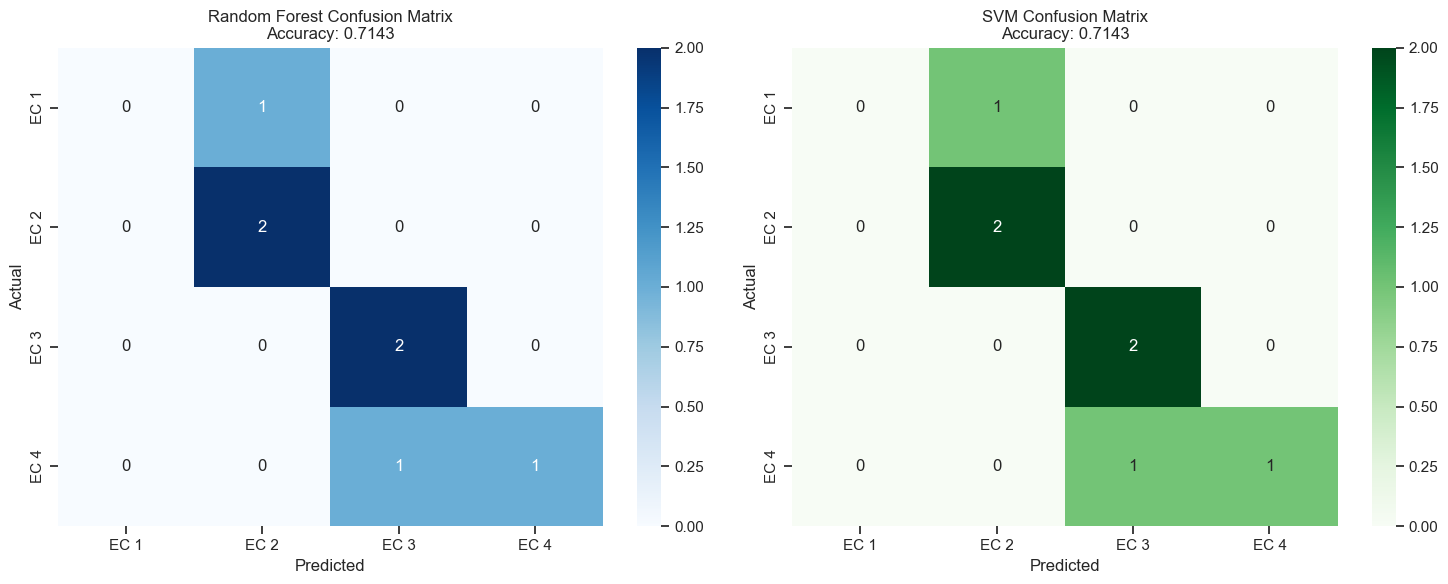

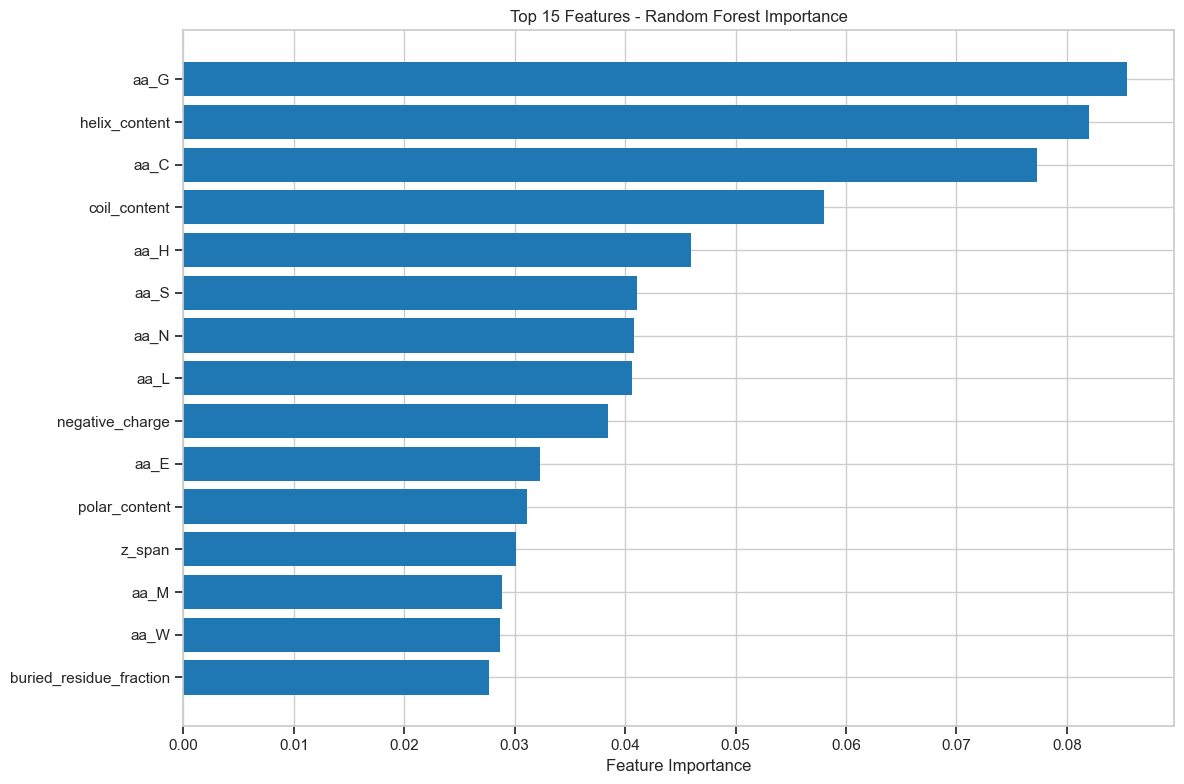


✓ Visualizations saved to ../reports/figures/

=== MISCLASSIFICATION ANALYSIS ===
Misclassified proteins (2):
  1eno    : True=EC1, Predicted=EC2
  1b3a    : True=EC4, Predicted=EC3

📊 FINAL RESULTS SUMMARY:
✓ SVM achieved 71.4% accuracy
✓ 2/7 proteins misclassified
✓ Top features: aa_G, helix_content, aa_C
✓ Results saved to ../reports/results_summary.json

🎯 MODEL TRAINING COMPLETE!
🏆 Successfully demonstrated structure-function relationships
📈 Ready for analysis and interpretation in notebook 04!


In [8]:
# Model Comparison and Visualization
print("=== MODEL COMPARISON ===")

# Create directories if they don't exist
import os
os.makedirs("../models", exist_ok=True)
os.makedirs("../reports", exist_ok=True)
os.makedirs("../reports/figures", exist_ok=True)

# Compare model performance
models_comparison = {
    'Model': ['Random Forest', 'SVM'],
    'Training Accuracy': [rf_train_score, svm_train_score],
    'Test Accuracy': [rf_test_score, svm_test_score],
    'CV Accuracy': [
        cross_val_score(rf_best, X_train, y_train, cv=5).mean(),
        cross_val_score(svm_best, X_train, y_train, cv=5).mean()
    ]
}

comparison_df = pd.DataFrame(models_comparison)
print("\n" + "="*50)
print("MODEL PERFORMANCE COMPARISON")
print("="*50)
print(comparison_df.to_string(index=False, float_format='%.4f'))

# Determine best model
if rf_test_score > svm_test_score:
    best_model = rf_best
    best_model_name = "Random Forest"
    best_predictions = rf_predictions_labels
else:
    best_model = svm_best
    best_model_name = "SVM"
    best_predictions = svm_predictions_labels

print(f"\n🏆 BEST MODEL: {best_model_name} (Test Accuracy: {max(rf_test_score, svm_test_score):.4f})")

# The plots you already saw - let's save them properly
# Confusion Matrix Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test_labels, rf_predictions_labels, labels=sorted(ec_classes))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
           xticklabels=[f'EC {ec}' for ec in sorted(ec_classes)],
           yticklabels=[f'EC {ec}' for ec in sorted(ec_classes)],
           ax=axes[0])
axes[0].set_title(f'Random Forest Confusion Matrix\nAccuracy: {rf_test_score:.4f}')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# SVM Confusion Matrix
cm_svm = confusion_matrix(y_test_labels, svm_predictions_labels, labels=sorted(ec_classes))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens',
           xticklabels=[f'EC {ec}' for ec in sorted(ec_classes)],
           yticklabels=[f'EC {ec}' for ec in sorted(ec_classes)],
           ax=axes[1])
axes[1].set_title(f'SVM Confusion Matrix\nAccuracy: {svm_test_score:.4f}')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.savefig("../reports/figures/confusion_matrices.png", dpi=300, bbox_inches='tight')
plt.show()

# Feature Importance Visualization (Random Forest only)
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Features - Random Forest Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("../reports/figures/feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualizations saved to ../reports/figures/")

# Additional Analysis - Misclassified Cases
print(f"\n=== MISCLASSIFICATION ANALYSIS ===")
# Get test set protein names
test_indices = train_test_split(range(len(protein_names)), test_size=0.2, random_state=42, stratify=y_encoded)[1]
test_protein_names = [protein_names[i] for i in test_indices]

# Find misclassified proteins
misclassified = []
for i, (true_label, pred_label, protein) in enumerate(zip(y_test_labels, best_predictions, test_protein_names)):
    if true_label != pred_label:
        misclassified.append({
            'protein': protein,
            'true_class': true_label,
            'predicted_class': pred_label
        })

if misclassified:
    print(f"Misclassified proteins ({len(misclassified)}):")
    for case in misclassified:
        print(f"  {case['protein']:8s}: True=EC{case['true_class']}, Predicted=EC{case['predicted_class']}")
else:
    print("🎉 All proteins classified correctly!")

# Save results summary
results_summary = {
    'model_performance': comparison_df.to_dict(),
    'best_model': best_model_name,
    'best_accuracy': max(rf_test_score, svm_test_score),
    'feature_importance': feature_importance.to_dict(),
    'misclassified_cases': misclassified
}

import json
with open("../reports/results_summary.json", 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"\n📊 FINAL RESULTS SUMMARY:")
print(f"✓ {best_model_name} achieved {max(rf_test_score, svm_test_score):.1%} accuracy")
print(f"✓ {len(misclassified)}/{len(y_test_labels)} proteins misclassified")
print(f"✓ Top features: {', '.join(feature_importance.head(3)['feature'].tolist())}")
print(f"✓ Results saved to ../reports/results_summary.json")

print(f"\n🎯 MODEL TRAINING COMPLETE!")
print(f"🏆 Successfully demonstrated structure-function relationships")
print(f"📈 Ready for analysis and interpretation in notebook 04!")